In [1]:

#print hdu[0].header.cards

import Analysis, Tools
import SourceMap
from astropy.wcs import WCS
from scipy.sparse import csr_matrix

from astropy import units as u
from astropy.coordinates import SkyCoord
reload(Analysis)

def AddExtendedSource(self, source, template_dir='/data/Extended_archive_v15/Templates/', fixed=True):
    """
    Add a 3FGL extended source to the analysis. 
    :param source: the FGL source name 
    """

    # Open FGL and look up the source name.
    hdu = pyfits.open(self.fglpath)
#     print hdu[5].data['2FGL_Name']
#     print hdu[5].header.cards
    # Find what the 3FGL catalog source name is of the requested source
    idx = -1
    for i_ext, name in enumerate(hdu[5].data['Source_Name']):
        if name == source:
            idx = i_ext
            break
    if idx == -1: 
        raise Exception('Extended source not %s found!'%source)
    #print 'source found at idx %i'%idx
    # Find the index of the extended source in the main catalog.
    idx_fgl = np.where(hdu[1].data['Source_Name']==hdu[5].data['2FGL_Name'][idx])[0]
    # Read the spatial template filename
    fname = hdu[5].data['Spatial_Filename'][idx]
    # Open the file and remove erroneous header info. 
    hdu_spatial = pyfits.open(template_dir+'/'+fname, 'readonly')
    try:
        hdu_spatial[0].header.pop('COMMENT')
    except:
        pass
    try:
        hdu_spatial[0].header.pop('HISTORY')
    except:
        pass
    
    # Read the WCS coordinates
    w = WCS(hdu_spatial[0].header, relax=False, fix=True)
    
    
    # Init a blank healpix template
    t = np.zeros(12*self.nside**2, dtype=np.float32)
    # Map the FGL extended template into healpix space, row by row. 
    for i_row in range(hdu_spatial[0].data.shape[0]):
        # get lat/lon for each row
        lon, lat = w.all_pix2world(i_row,np.arange(hdu_spatial[0].data.shape[1]), 0)
        c_icrs = SkyCoord(ra=lon, dec=lat, frame='icrs', unit='degree')
        lon,lat = c_icrs.galactic.l.degree, c_icrs.galactic.b.degree
        # transform lat/lon to healpix
        hpix_idx = Tools.ang2hpix(lon, lat, nside=self.nside)
        # Add these counts to the healpix template
        np.add.at(t, hpix_idx, hdu_spatial[0].data[i_row,:])
        
        
    # Get the total number of counts from this source in each energy bin.  This will set the normalization
    total_counts = np.sum(self.GenPointSourceTemplate(pscmap=None, onlyidx=[idx_fgl,], save=False, verbosity=0), axis=1)
    print total_counts
    
    # Generate a master sourcemap for the extended source (spatial template for each energy bin). 
    master_t = np.array([t for i_E, count in enumerate(total_counts)])
    for i_E, count in enumerate(total_counts):
        #master_t[i_E] = master_t[i_E]/np.sum(master_t[i_E])*count # normed to the expected PSC flux
        # Apply the PSF 
        master_t[i_E] = Tools.ApplyGaussianPSF(master_t[i_E], E_min=self.bin_edges[i_E], E_max=self.bin_edges[i_E+1], psfFile=self.psfFile, multiplier=1.)
    
    # Convert to sparse matrix for memory profile. 
    t_sparse = csr_matrix(master_t , dtype=np.float32)
    self.AddTemplate(source.replace(' ',''), t_sparse, fixSpectrum=fixed, fixNorm=fixed,
                             limits=[None, None], value=1., ApplyIRF=False, sourceClass='FGL')
    

    
    
    
A = Analysis.Analysis()
A.PopulateROI([0,0],radius=360, fix_radius=360, include_point=False)

import healpy
#healpy.cartview(A.templateList['CenALobes'].healpixCube[0].toarray()[0])

Populating ROI with point sources: 123 of 3034
Populating ROI with point sources: 603 of 3034
Populating ROI with point sources: 640 of 3034
Populating ROI with point sources: 697 of 3034
Populating ROI with point sources: 930 of 3034
Populating ROI with point sources: 956 of 3034
Populating ROI with point sources: 1001 of 3034
Populating ROI with point sources: 1568 of 3034
Populating ROI with point sources: 1624 of 3034
Populating ROI with point sources: 1848 of 3034
Populating ROI with point sources: 1963 of 3034
Populating ROI with point sources: 1966 of 3034
Populating ROI with point sources: 2020 of 3034
Populating ROI with point sources: 2120 of 3034
Populating ROI with point sources: 2275 of 3034
Populating ROI with point sources: 2287 of 3034
Populating ROI with point sources: 2355 of 3034
Populating ROI with point sources: 2393 of 3034
Populating ROI with point sources: 2406 of 3034
Populating ROI with point sources: 2441 of 3034
Populating ROI with point sources: 2500 of 303

In [11]:
hdu = pyfits.open('/data/Extended_archive_v15/Templates//S147.fits')
hdu.info()

Filename: /data/Extended_archive_v15/Templates//S147.fits
No.    Name         Type      Cards   Dimensions   Format
0    PRIMARY     PrimaryHDU      22   (95, 95)     float32   


In [68]:
A.AddTemplate(name='PSCExt', healpixCube=master, fixSpectrum=True, fixNorm=True,ApplyIRF=False, noPSF=True)

                NAME                    LIMITS      VALUE    FIXNORM    FIXSPEC   SRCCLASS
           CenALobes              [None, None]  1.000e+00       True       True        FGL


In [123]:
c_icrs = SkyCoord(ra=2*u.degree, dec=1*u.degree, frame='icrs')

In [5]:
psc = np.load('PSC_3FGL_with_ext.npy')

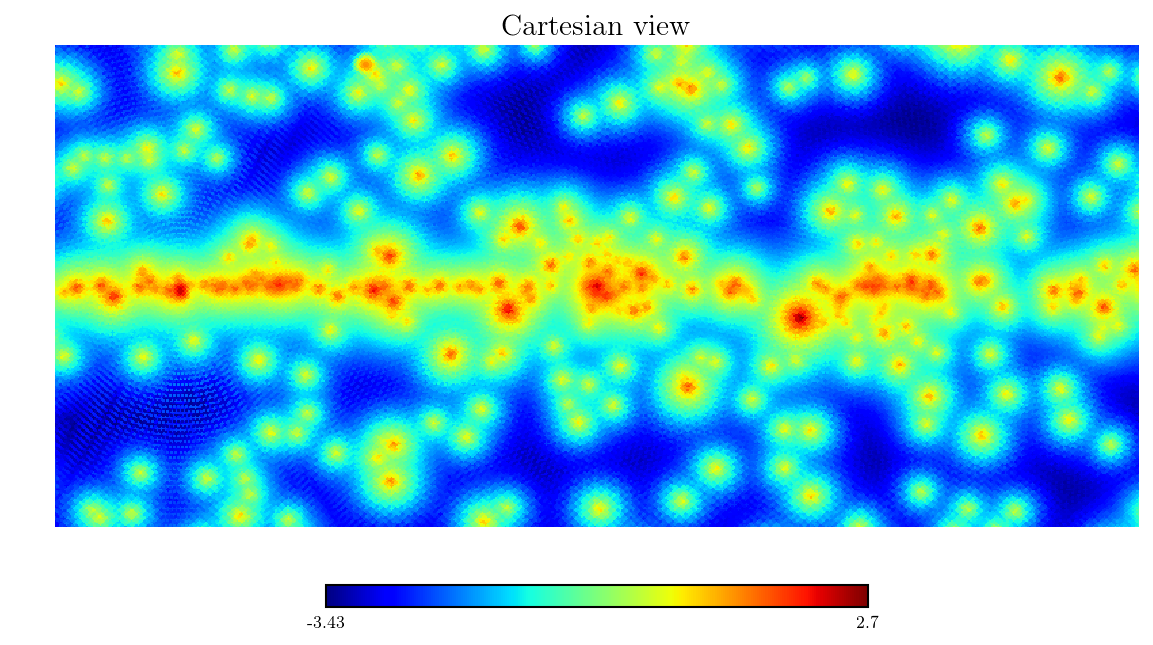

In [13]:
import healpy
healpy.cartview(np.log10(psc[10]), latra=[-20,20],lonra=[-45,45])

In [2]:
A.PrintTemplates()

                NAME                    LIMITS      VALUE    FIXNORM    FIXSPEC   SRCCLASS
             PuppisA              [None, None]  1.000e+00      False      False        FGL
       HESSJ1614n518              [None, None]  1.000e+00      False      False        FGL
       HESSJ1616n508              [None, None]  1.000e+00      False      False        FGL
           CenALobes              [None, None]  1.000e+00      False      False        FGL
       HESSJ1632n478              [None, None]  1.000e+00      False      False        FGL
       HESSJ1837n069              [None, None]  1.000e+00      False      False        FGL
                 SMC              [None, None]  1.000e+00      False      False        FGL
                 W28              [None, None]  1.000e+00      False      False        FGL
                 W44              [None, None]  1.000e+00      False      False        FGL
              VelaJr              [None, None]  1.000e+00      False      False        FGL

In [27]:
master = np.zeros(A.templateList['W51C'].healpixCube.shape)
for key, t in A.templateList.items():
    master += t.healpixCube.toarray()

    
#master +=     

[[ 0.00030675  0.0003124   0.00038025 ...,  0.00057779  0.00057213
   0.00059987]
 [ 0.00031824  0.0003214   0.00042673 ...,  0.00064225  0.00062737
   0.00067241]
 [ 0.00031657  0.00031713  0.00044032 ...,  0.00065047  0.00062845
   0.00068421]
 ..., 
 [ 0.00049763  0.00064341  0.00091843 ...,  0.00094029  0.00096671
   0.00043376]
 [ 0.00036719  0.0003293   0.00051302 ...,  0.00054773  0.00061616
   0.00035951]
 [ 0.00028971  0.00025498  0.00032052 ...,  0.00030551  0.00039444
   0.00028107]]


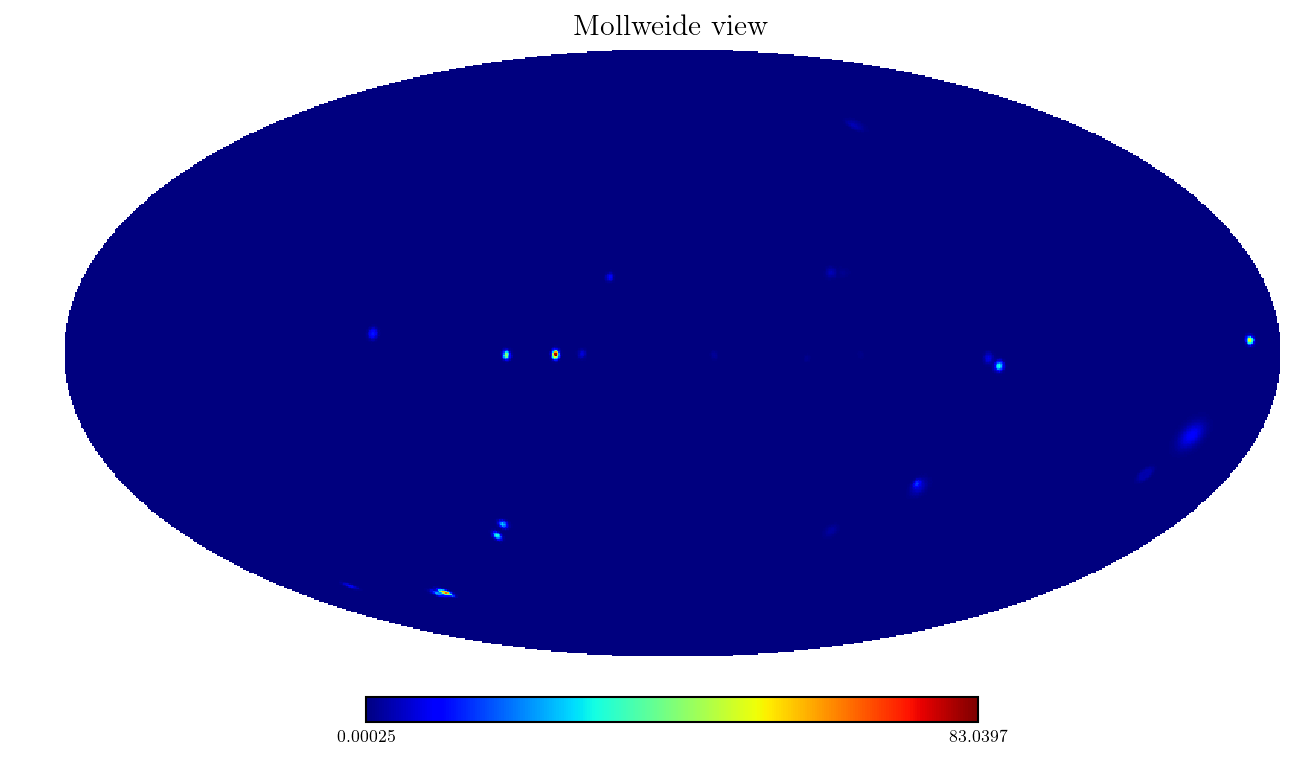

In [28]:
import healpy
print master

healpy.mollview(master[0])

In [17]:
sqrt(786432/12)

256.0

/home/carlson/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:5: RuntimeWarning: divide by zero encountered in log10


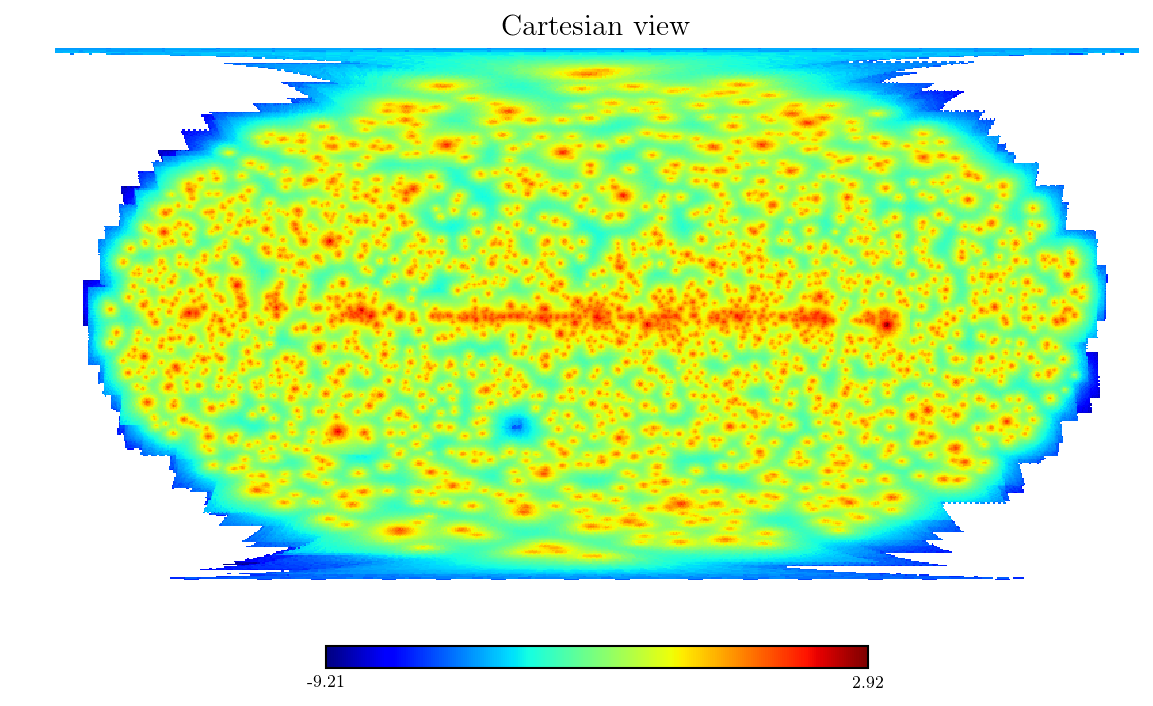

In [32]:


#test = np.load('PSC_3FGL_with_ext.npy')
test = np.load('PSC_P8R2_PSF3_CLEAN_V6_calore_fgl3.npy')
healpy.cartview(np.log10(test[4]))

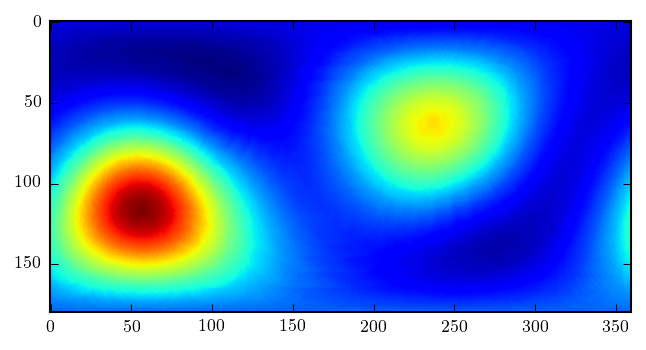

In [82]:
h = pyfits.open('gtexpcube2_P8R2_CLEAN_V6_calore.fits')
#binned = np.load('binned_photons_P8R2_PSF3_CLEAN_V6_calore.npy')

#healpy.cartview(np.log10(binned[0]))
#h.info()

#print h[1].header.cards
plt.imshow(h[0].data[10])

#print h[0].data.shape
#healpy.cartview(h[0].data[0])




#np.load('gtexpcube2_P8R2_PSF3_CLEAN_V6_calore.fits')

In [63]:
sqrt(49152/12)

64.0